# Discretiser - Journey Simulation Examples

This notebook demonstrates the discretiser framework for simulating patient journeys with competing events.

**Note:** These examples are illustrative of the framework's machinery rather than realistic clinical models. In particular:
- Survival parameters are arbitrary, not calibrated to real data
- Outcome/censoring do not depend on treatment history
- No neural network integration for state-dependent dynamics

The framework supports all of the above via custom `SurvivalModel` subclasses that access `state` features (event counts, times, embeddings) in their `sample()` method.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add parent directory to path so discretiser package can be found
repo_root = Path.cwd().parent.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
from discretiser.src import (
    # Survival models
    Weibull, Exponential, PointMassPlusContinuous, Mixture, NeverOccurs,
    StateDependentWeibull, MinSurvival,
    # Events
    EventType, EventRegistry, TriggerRule,
    make_censoring_event, make_terminal_event, make_triggering_event,
    # State
    Subject, State, generate_subjects,
    # Simulator
    Simulator, simulate_journey, simulate_cohort_simple
)

## 1. Basic Example: Simple Patient Journey

A simple model with diagnosis, treatment, outcome, and censoring.

In [3]:
# Define event types with realistic dependencies
# Diagnosis occurs once, but treatment can recur (e.g., multiple sessions)
diagnosis = EventType('diagnosis', Weibull(shape=1.5, scale=30))
diagnosis.active_condition = lambda state, _: 'diagnosis' not in state.occurred_events

# Treatment only possible after diagnosis, can recur
treatment = EventType('treatment', Weibull(shape=1.2, scale=14))
treatment.active_condition = lambda state, _: 'diagnosis' in state.occurred_events

events = [
    diagnosis,
    treatment,
    EventType('outcome', Weibull(shape=2.0, scale=180), terminal=True),
    make_censoring_event('censoring', Exponential(rate=1/365))
]

# Simulate a cohort
df = simulate_cohort_simple(n_subjects=200, events=events, max_time=365)
print(f"Total events: {len(df)}")
print(f"Events per subject: {df.groupby('subject_id').size().describe()}")
df['event'].value_counts()

Total events: 3369
Events per subject: count    200.000000
mean      16.845000
std       10.434335
min        1.000000
25%        8.000000
50%       17.000000
75%       26.000000
max       39.000000
dtype: float64


event
treatment    3049
diagnosis     183
censoring     115
outcome        22
Name: count, dtype: int64

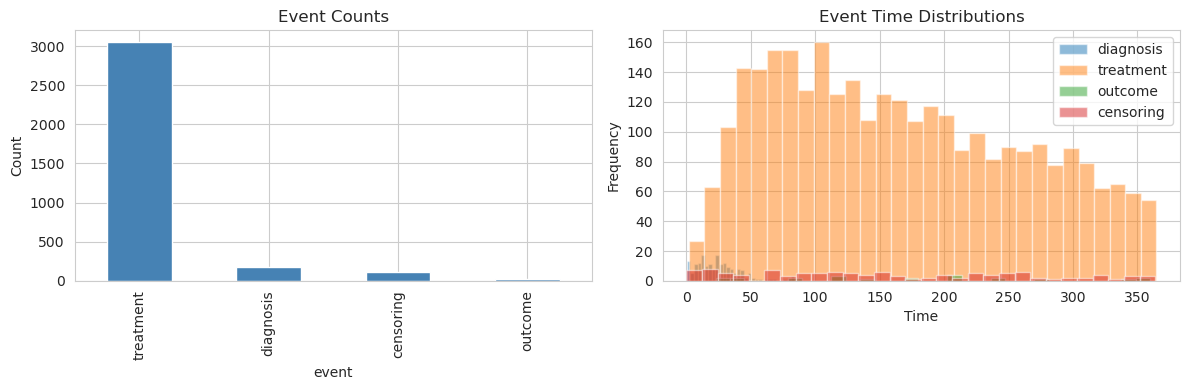

In [4]:
# Visualise event times
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Event counts
df['event'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Event Counts')
axes[0].set_ylabel('Count')

# Time distribution by event
for event in df['event'].unique():
    subset = df[df['event'] == event]
    axes[1].hist(subset['time'], bins=30, alpha=0.5, label=event)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Event Time Distributions')
axes[1].legend()

plt.tight_layout()
plt.show()

## 2. Triggered Events: Diagnosis Triggers Treatment

Using `PointMassPlusContinuous` to model simultaneous events:
- 30% chance treatment starts immediately at diagnosis
- 70% chance treatment follows a Weibull distribution

In [5]:
# Diagnosis can trigger treatment (diagnosis occurs once)
diagnosis = make_triggering_event(
    name='diagnosis',
    survival_model=Weibull(1.5, 60),
    triggers={
        # 30% immediate, 70% follows Weibull (competing with other events)
        'treatment': PointMassPlusContinuous(p0=0.3, continuous=Weibull(1.2, 14))
    }
)
diagnosis.active_condition = lambda state, _: 'diagnosis' not in state.occurred_events

# Treatment can also recur independently after first occurrence
# (e.g., follow-up treatments after the triggered one)
treatment = EventType('treatment', Weibull(1.5, 30))
treatment.active_condition = lambda state, _: 'treatment' in state.occurred_events

# Note: To model "sometimes no treatment at all", use Mixture with NeverOccurs:
#   Mixture(
#       models=[NeverOccurs(), PointMassPlusContinuous(0.3, Weibull(1.2, 14))],
#       weights=[0.2, 0.8]  # 20% never triggered, 80% triggered
#   )

events_triggered = [
    diagnosis,
    treatment,
    EventType('outcome', Weibull(2.0, 180), terminal=True),
    make_censoring_event('censoring', Exponential(rate=1/365))
]

df_triggered = simulate_cohort_simple(n_subjects=200, events=events_triggered, max_time=365)
print("Events per subject:", df_triggered.groupby('subject_id').size().describe())
print("\nTriggered events breakdown:")
print(df_triggered['triggered_by'].value_counts(dropna=False))

Events per subject: count    200.000000
mean       7.040000
std        5.227334
min        1.000000
25%        2.000000
50%        6.000000
75%       11.250000
max       21.000000
dtype: float64

Triggered events breakdown:
triggered_by
None         1260
diagnosis     148
Name: count, dtype: int64


Total treatments: 1102
Simultaneous (delay=0): 46
Delayed (delay>0): 1056


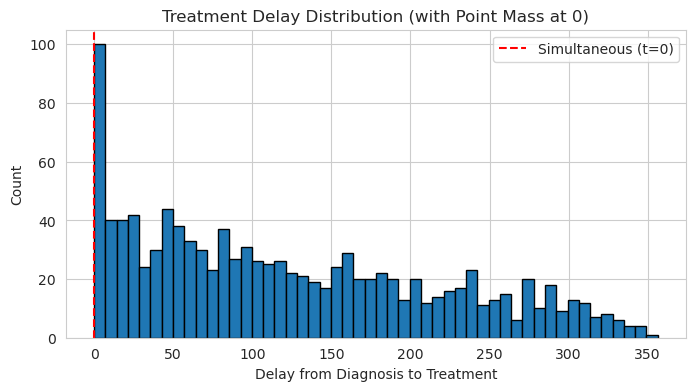

In [6]:
# Analyse delay from diagnosis to first treatment
# Use merge_asof to correctly match each treatment to the preceding diagnosis
treatments = df_triggered[df_triggered['event'] == 'treatment'].copy()
diagnoses = df_triggered[df_triggered['event'] == 'diagnosis'][['subject_id', 'time']].copy()
diagnoses = diagnoses.rename(columns={'time': 'diagnosis_time'})

# Sort by the merge key for merge_asof
treatments_sorted = treatments.sort_values('time')
diagnoses_sorted = diagnoses.sort_values('diagnosis_time')

# Match each treatment to the most recent diagnosis before it
merged = pd.merge_asof(
    treatments_sorted,
    diagnoses_sorted,
    left_on='time',
    right_on='diagnosis_time',
    by='subject_id',
    direction='backward'
)
merged['delay'] = merged['time'] - merged['diagnosis_time']

print(f"Total treatments: {len(merged)}")
print(f"Simultaneous (delay=0): {(merged['delay'] == 0).sum()}")
print(f"Delayed (delay>0): {(merged['delay'] > 0).sum()}")

# Plot delay distribution
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(merged['delay'].dropna(), bins=50, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', label='Simultaneous (t=0)')
ax.set_xlabel('Delay from Diagnosis to Treatment')
ax.set_ylabel('Count')
ax.set_title('Treatment Delay Distribution (with Point Mass at 0)')
ax.legend()
plt.show()

## 3. Subject-Dependent Survival (Covariates)

Subject features can modify survival model parameters. Here we show how to create
subject-dependent Weibull parameters where the scale depends on subject features.

In [7]:
class SubjectDependentWeibull(Weibull):
    """
    Weibull where scale depends on subject features.
    
    scale_adjusted = base_scale * exp(subject_features @ coefficients)
    """
    
    def __init__(self, shape: float, base_scale: float, coefficients: np.ndarray):
        super().__init__(shape, base_scale)
        self.base_scale = base_scale
        self.coefficients = coefficients
    
    def sample(self, state=None, subject=None) -> float:
        if subject is not None and subject.feature_vector is not None:
            # Adjust scale based on subject features
            log_modifier = np.dot(subject.feature_vector, self.coefficients)
            adjusted_scale = self.base_scale * np.exp(log_modifier)
        else:
            adjusted_scale = self.base_scale
        
        return adjusted_scale * np.random.weibull(self.shape)

# Feature dimension = 4, create coefficients
# Positive coefficients -> longer time to event
coef_diagnosis = np.array([0.5, -0.3, 0.2, -0.1])  # Feature effects on diagnosis timing
coef_outcome = np.array([-0.4, 0.3, -0.2, 0.5])    # Feature effects on outcome timing

print("Coefficients for diagnosis:", coef_diagnosis)
print("Coefficients for outcome:", coef_outcome)

Coefficients for diagnosis: [ 0.5 -0.3  0.2 -0.1]
Coefficients for outcome: [-0.4  0.3 -0.2  0.5]


In [8]:
# Create events with subject-dependent survival
# Diagnosis once, treatment can recur
diagnosis_cov = EventType('diagnosis', SubjectDependentWeibull(1.5, 60, coef_diagnosis))
diagnosis_cov.active_condition = lambda state, _: 'diagnosis' not in state.occurred_events

treatment_cov = EventType('treatment', Weibull(1.2, 14))
treatment_cov.active_condition = lambda state, _: 'diagnosis' in state.occurred_events

events_covariate = [
    diagnosis_cov,
    treatment_cov,
    EventType('outcome', SubjectDependentWeibull(2.0, 180, coef_outcome), terminal=True),
    make_censoring_event('censoring', Exponential(rate=1/365))
]

# Generate subjects with different feature profiles
subjects = generate_subjects(n=200, feature_dim=4, dirichlet_alpha=0.5)

# Show feature distribution
features_df = pd.DataFrame(
    [s.feature_vector for s in subjects],
    columns=[f'f{i}' for i in range(4)]
)
print("Subject feature summary:")
print(features_df.describe())

Subject feature summary:
               f0          f1          f2          f3
count  200.000000  200.000000  200.000000  200.000000
mean     0.245608    0.252688    0.249880    0.251824
std      0.255932    0.256804    0.260653    0.260846
min      0.000185    0.000014    0.000004    0.000010
25%      0.026924    0.042693    0.041053    0.038643
50%      0.156206    0.142040    0.158533    0.157486
75%      0.414536    0.418830    0.393695    0.420410
max      0.961153    0.984005    0.979142    0.900458


In [9]:
# Run simulation
registry = EventRegistry()
registry.register_all(events_covariate)

simulator = Simulator(registry, max_time=365)
results = simulator.simulate_cohort(subjects)

df_covariate = simulator.cohort_to_dataframe(results)
print(f"Total events: {len(df_covariate)}")
df_covariate['event'].value_counts()

Total events: 2472


event
treatment    2175
diagnosis     149
censoring     114
outcome        34
Name: count, dtype: int64

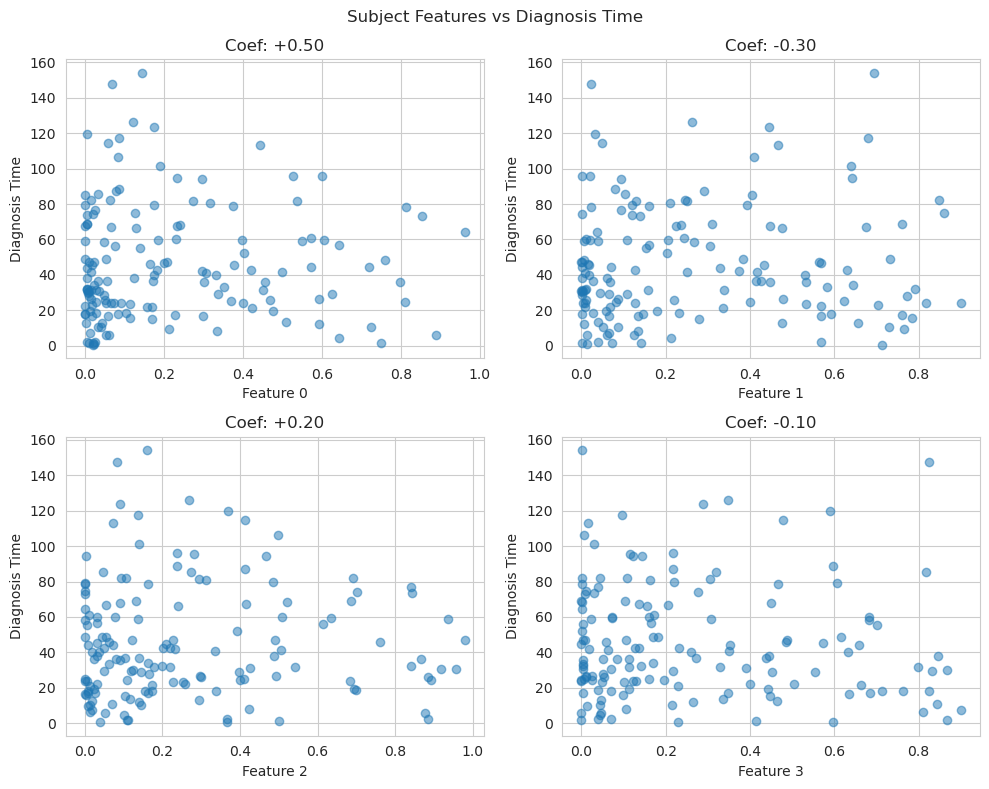

In [10]:
# Analyse relationship between subject features and event times
# Get first diagnosis time per subject
first_diagnosis = df_covariate[df_covariate['event'] == 'diagnosis'].groupby('subject_id')['time'].min()

# Merge with features
analysis_df = features_df.copy()
analysis_df['subject_id'] = [s.id for s in subjects]
analysis_df['diagnosis_time'] = analysis_df['subject_id'].map(first_diagnosis)

# Plot feature vs diagnosis time
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    col = f'f{i}'
    valid = analysis_df.dropna(subset=['diagnosis_time'])
    ax.scatter(valid[col], valid['diagnosis_time'], alpha=0.5)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel('Diagnosis Time')
    ax.set_title(f'Coef: {coef_diagnosis[i]:+.2f}')

plt.suptitle('Subject Features vs Diagnosis Time')
plt.tight_layout()
plt.show()

## 4. Visualising Individual Journeys

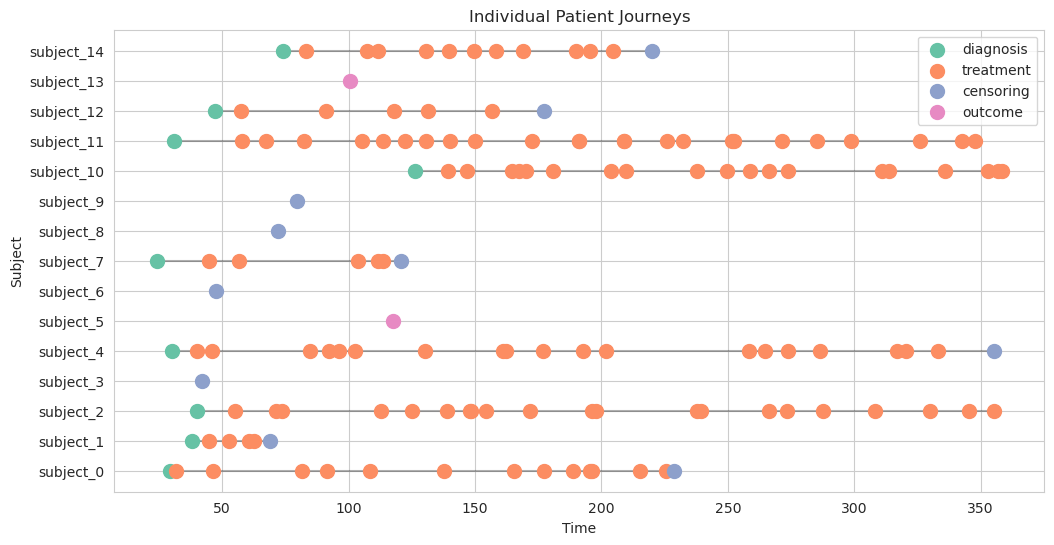

In [11]:
def plot_journeys(df, n_subjects=10):
    """Plot event timelines for a sample of subjects."""
    subjects = df['subject_id'].unique()[:n_subjects]
    
    # Assign colours to events
    event_types = df['event'].unique()
    colours = dict(zip(event_types, plt.cm.Set2.colors[:len(event_types)]))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, subj in enumerate(subjects):
        subj_df = df[df['subject_id'] == subj].sort_values('time')
        for _, row in subj_df.iterrows():
            ax.scatter(row['time'], i, c=[colours[row['event']]], s=100, zorder=3)
        # Connect events with line
        ax.plot(subj_df['time'], [i] * len(subj_df), 'k-', alpha=0.3, zorder=1)
    
    # Legend
    for event, colour in colours.items():
        ax.scatter([], [], c=[colour], label=event, s=100)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Subject')
    ax.set_yticks(range(len(subjects)))
    ax.set_yticklabels(subjects)
    ax.legend(loc='upper right')
    ax.set_title('Individual Patient Journeys')
    
    return fig, ax

plot_journeys(df_covariate, n_subjects=15)
plt.show()

## 5. Single Journey Simulation

The `simulate_journey` function provides a convenient API for simulating individual subjects. It returns a `SimulationResult` object with access to the full event history and termination status.

In [ ]:
# Create a single subject
subject = Subject(id='patient_001', feature_vector=np.array([0.3, 0.4, 0.2, 0.1]))

# Simple event configuration
events_simple = [
    EventType('diagnosis', Weibull(1.5, 30)),
    EventType('treatment', Weibull(1.2, 20)),
    EventType('outcome', Weibull(2.0, 180), terminal=True),
    make_censoring_event('censoring', Exponential(rate=1/365))
]

# Simulate a single journey
result = simulate_journey(subject, events_simple, max_time=365)

# Access the result
print(f"Subject: {result.subject.id}")
print(f"Final time: {result.final_time:.2f}")
print(f"Terminated: {result.terminated}")
print(f"Censored: {result.censored}")
print(f"\nEvent history ({len(result.history)} events):")
for event in result.history:
    print(f"  t={event.time:.2f}: {event.event_name}")

### Autoregressive Mode

The simulator supports two modes:
- **competing** (default): Pending events persist until they occur or are cancelled
- **autoregressive**: Pending events get one chance to compete; after each event all pending is cleared

Autoregressive mode is more natural for sequence models that predict "next event | history".

In [ ]:
# Compare competing vs autoregressive modes
# Use triggered events to see the difference

# Diagnosis triggers a delayed treatment (Weibull distributed delay)
events_with_trigger = [
    make_triggering_event(
        name='diagnosis',
        survival_model=Weibull(1.5, 30),
        triggers={'treatment': Weibull(1.2, 10)}  # Treatment triggered with delay
    ),
    EventType('outcome', Weibull(2.0, 180), terminal=True),
    make_censoring_event('censoring', Exponential(rate=1/365))
]

# Setup both simulators
registry = EventRegistry()
registry.register_all(events_with_trigger)

sim_competing = Simulator(registry, max_time=365, mode='competing')
sim_autoregressive = Simulator(registry, max_time=365, mode='autoregressive')

# Run multiple simulations to compare
np.random.seed(42)
n_sims = 100
subjects_test = generate_subjects(n=n_sims, feature_dim=4)

results_competing = [sim_competing.simulate_subject(s) for s in subjects_test]
results_autoregressive = [sim_autoregressive.simulate_subject(s) for s in subjects_test]

# Count how often treatment actually occurs
def count_event(results, event_name):
    return sum(1 for r in results if any(e.event_name == event_name for e in r.history))

print("Event occurrence rates:")
print(f"  Competing mode:")
print(f"    Treatment: {count_event(results_competing, 'treatment')}/{n_sims}")
print(f"  Autoregressive mode:")
print(f"    Treatment: {count_event(results_autoregressive, 'treatment')}/{n_sims}")

### Inspecting Pending Events

You can also use the `Simulator.simulate_subject` method directly to access the full `State` object, which allows inspecting pending events during simulation.

In [ ]:
# Demonstrate state and pending event inspection
# Create state manually to show the API
subject = Subject(id='demo', feature_vector=np.array([0.25, 0.25, 0.25, 0.25]))
state = State(subject)

# Record a diagnosis at time 10
state.advance_time(10.0)
state.record_event('diagnosis', 10.0)

# Add a pending treatment (triggered by diagnosis, scheduled for time 18)
state.add_pending_event('treatment', 18.0, triggered_by='diagnosis')

print("State at t=10 after diagnosis:")
print(f"  Current time: {state.time}")
print(f"  Occurred events: {state.occurred_events}")
print(f"  Event counts: {dict(state.event_counts)}")
print(f"  Pending events: {state.get_pending_events()}")
print(f"  Pending summary: {state.get_pending_summary()}")

# Advance time - the pending event is now closer
state.advance_time(15.0)
print(f"\nAt t=15:")
print(f"  Pending summary: {state.get_pending_summary()}")

# The pending event would now compete with other sampled events at time 18

## Summary

The discretiser framework provides:

1. **Survival Models**: Weibull, Exponential, LogNormal, Gamma, and composites
2. **Point Masses**: For simultaneous events via `PointMassPlusContinuous`
3. **Event Triggering**: One event can trigger others with specified timing
4. **Subject Covariates**: Survival parameters can depend on subject features
5. **Competing Risks**: Multiple events compete; winner is minimum time
6. **Terminal Events**: Outcome and censoring end the simulation
7. **Single Journey Simulation**: `simulate_journey` for individual subject trajectories
8. **Autoregressive Mode**: One-shot pending events for sequence model compatibility
9. **Truncated Distributions**: `model.truncate(elapsed)` for conditional sampling
10. **MinSurvival**: General competing risks (minimum of multiple distributions)